In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'

data = np.load(filename)

train = data[:49000, 8192:]
vali = data[49000:, 8192:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 10240])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 10])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 10, 64])
b_conv1_1 = bias_variable([64])

h_conv1_1 = tf.nn.relu(conv2d(x_image, w_conv1_1) + b_conv1_1)
h_pool1 = max_pool_2x2(h_conv1_1)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2)
h_pool2 = max_pool_2x2(h_conv2_2)

# fc_3
w_conv3_1 = weight_variable([3, 3, 128, 256])
b_conv3_1 = bias_variable([256])

w_conv3_2 = weight_variable([3, 3, 256, 256])
b_conv3_2 = bias_variable([256])

h_conv3_1 = tf.nn.relu(conv2d(h_pool2, w_conv3_1) + b_conv3_1)
h_conv3_2 = tf.nn.relu(conv2d(h_conv3_1, w_conv3_2) + b_conv3_2)
h_pool3 = max_pool_2x2(h_conv3_2)


# flatten
h_pool2_flat = tf.reshape(h_pool3, [-1, 4*4*256])

# densely connected layer
w_fc1 = weight_variable([4*4*256, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([1024, 1024])
b_fc2 = bias_variable([1024])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([1024, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
gamma = 1e-2
delta = 1e-7
learning_rate = 1e-4
L2_norm = gamma*(tf.norm(w_fc3)+tf.norm(w_fc2)+tf.norm(w_fc1)+
                 tf.norm(w_conv1_1)+tf.norm(w_conv2_1)+tf.norm(w_conv2_2)+tf.norm(w_conv3_1)+tf.norm(w_conv3_2))
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+ L2_norm
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 1024
step_num = 10000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))



The shape of train is  (49000, 10257)
The shape of vali is  (1989, 10257)
step 0, train accuracy 0.0683594, vali accuracy 0.0673705, train loss 15342.1
step 200, train accuracy 0.15918, vali accuracy 0.145802, train loss 13874.9
step 400, train accuracy 0.217773, vali accuracy 0.224233, train loss 12844.6
step 600, train accuracy 0.279297, vali accuracy 0.277024, train loss 11842
step 800, train accuracy 0.345703, vali accuracy 0.328306, train loss 10764.6
step 1000, train accuracy 0.330078, vali accuracy 0.341378, train loss 10958.4
step 1200, train accuracy 0.376953, vali accuracy 0.372046, train loss 9794.7
step 1400, train accuracy 0.563477, vali accuracy 0.535948, train loss 1358.62
step 1600, train accuracy 0.618164, vali accuracy 0.575666, train loss 1181.94
step 1800, train accuracy 0.621094, vali accuracy 0.616893, train loss 1103.61
step 2000, train accuracy 0.677734, vali accuracy 0.639015, train loss 966.291
step 2200, train accuracy 0.692383, vali accuracy 0.653092, train 

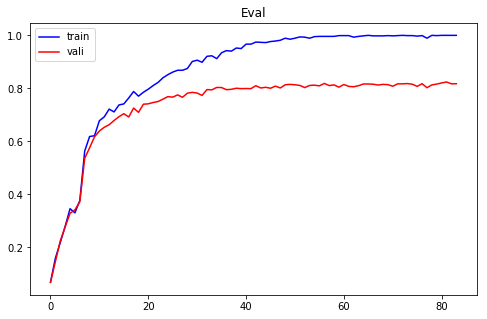

In [4]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

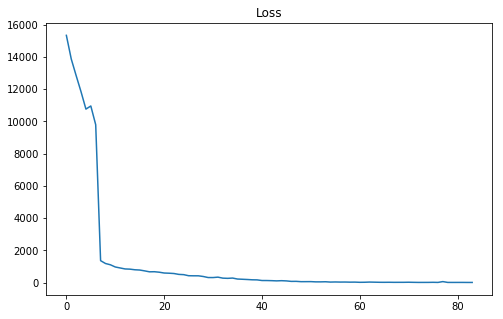

In [5]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

In [6]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.75      0.77      0.76       115
          1       0.73      0.69      0.71       107
          2       0.80      0.78      0.79       130
          3       0.74      0.69      0.71       118
          4       0.66      0.54      0.59       141
          5       0.69      0.77      0.73       122
          6       0.94      0.91      0.92       121
          7       0.81      0.85      0.83       136
          8       0.83      0.82      0.83       117
          9       0.63      0.70      0.66        97
         10       0.91      0.97      0.94       108
         11       0.81      0.83      0.82       100
         12       0.94      0.87      0.90       112
         13       0.90      0.94      0.92       114
         14       0.93      0.95      0.94       107
         15       0.95      0.95      0.95       138
         16       0.99      1.00      1.00       106

avg / total       0.82      0.82      0.82  

##### 6层卷积+3层全连接

In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'

data = np.load(filename)

train = data[:49000, 8192:]
vali = data[49000:, 8192:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 10240])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 10])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 10, 64])
b_conv1_1 = bias_variable([64])

w_conv1_2 = weight_variable([3, 3, 64, 64])
b_conv1_2 = bias_variable([64])

h_conv1_1 = tf.nn.relu(conv2d(x_image, w_conv1_1) + b_conv1_1)
h_conv1_2 = tf.nn.relu(conv2d(h_conv1_1, w_conv1_2) + b_conv1_2)
h_pool1 = max_pool_2x2(h_conv1_2)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2)
h_pool2 = max_pool_2x2(h_conv2_2)

# fc_3
w_conv3_1 = weight_variable([3, 3, 128, 256])
b_conv3_1 = bias_variable([256])

w_conv3_2 = weight_variable([3, 3, 256, 256])
b_conv3_2 = bias_variable([256])

h_conv3_1 = tf.nn.relu(conv2d(h_pool2, w_conv3_1) + b_conv3_1)
h_conv3_2 = tf.nn.relu(conv2d(h_conv3_1, w_conv3_2) + b_conv3_2)
h_pool3 = max_pool_2x2(h_conv3_2)


# flatten
h_pool2_flat = tf.reshape(h_pool3, [-1, 4*4*256])

# densely connected layer
w_fc1 = weight_variable([4*4*256, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([1024, 1024])
b_fc2 = bias_variable([1024])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([1024, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
gamma = 1e-2
delta = 1e-7
learning_rate = 1e-4
L2_norm = gamma*(tf.norm(w_fc3)+tf.norm(w_fc2)+tf.norm(w_fc1)+
                 tf.norm(w_conv1_1)+tf.norm(w_conv1_2)+tf.norm(w_conv2_1)+tf.norm(w_conv2_2)+tf.norm(w_conv3_1)+tf.norm(w_conv3_2))
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+ L2_norm
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 1024
step_num = 10000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))



The shape of train is  (49000, 10257)
The shape of vali is  (1989, 10257)
step 0, train accuracy 0.0458984, vali accuracy 0.0372046, train loss 15591
step 200, train accuracy 0.175781, vali accuracy 0.171946, train loss 13608.2
step 400, train accuracy 0.197266, vali accuracy 0.182504, train loss 13185.6
step 600, train accuracy 0.241211, vali accuracy 0.231272, train loss 12528.2
step 800, train accuracy 0.254883, vali accuracy 0.248869, train loss 12302.5
step 1000, train accuracy 0.257812, vali accuracy 0.252891, train loss 12254.1
step 1200, train accuracy 0.25293, vali accuracy 0.254399, train loss 12320.8
step 1400, train accuracy 0.272461, vali accuracy 0.246355, train loss 12012.1
step 1600, train accuracy 0.266602, vali accuracy 0.25088, train loss 12106.7
step 1800, train accuracy 0.269531, vali accuracy 0.279537, train loss 12031.3
step 2000, train accuracy 0.253906, vali accuracy 0.264455, train loss 12276.1
step 2200, train accuracy 0.273438, vali accuracy 0.288587, train 

In [2]:
step_num = 10000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))

step 0, train accuracy 0.981445, vali accuracy 0.812971, train loss 74.7883
step 200, train accuracy 0.990234, vali accuracy 0.809955, train loss 54.8649
step 400, train accuracy 0.984375, vali accuracy 0.81096, train loss 71.1024
step 600, train accuracy 0.981445, vali accuracy 0.815485, train loss 72.4239
step 800, train accuracy 0.987305, vali accuracy 0.800402, train loss 72.7486
step 1000, train accuracy 0.996094, vali accuracy 0.812469, train loss 38.1854
step 1200, train accuracy 0.993164, vali accuracy 0.811463, train loss 42.0532
step 1400, train accuracy 0.995117, vali accuracy 0.812971, train loss 33.0302
step 1600, train accuracy 0.998047, vali accuracy 0.814982, train loss 20.9213
step 1800, train accuracy 0.99707, vali accuracy 0.815988, train loss 30.2728
step 2000, train accuracy 0.999023, vali accuracy 0.817999, train loss 23.3689
step 2200, train accuracy 0.993164, vali accuracy 0.808949, train loss 27.3834
step 2400, train accuracy 0.998047, vali accuracy 0.812469, t

KeyboardInterrupt: 

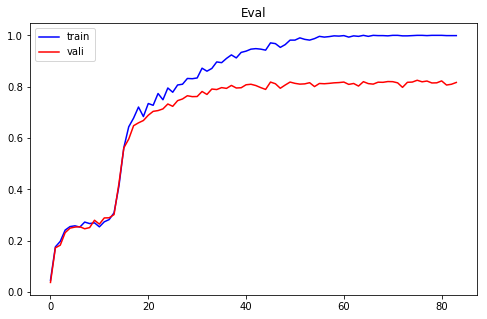

In [3]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

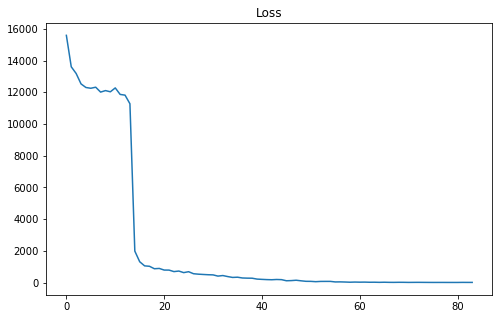

In [4]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

In [5]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.70      0.86      0.77       115
          1       0.76      0.69      0.72       107
          2       0.76      0.80      0.78       130
          3       0.64      0.69      0.66       118
          4       0.62      0.52      0.57       141
          5       0.70      0.73      0.71       122
          6       0.93      0.94      0.94       121
          7       0.83      0.82      0.83       136
          8       0.89      0.79      0.84       117
          9       0.69      0.69      0.69        97
         10       0.94      0.90      0.92       108
         11       0.79      0.90      0.84       100
         12       0.92      0.85      0.88       112
         13       0.92      0.89      0.91       114
         14       0.91      0.98      0.95       107
         15       0.95      0.91      0.93       138
         16       1.00      0.99      1.00       106

avg / total       0.82      0.82      0.82  

* 5层卷积+3层全连接
* 使用shuffle全部数据作为训练集，在train.h5中随机抽取5k样本做validation
* batch_size:1024
* learning_rate:1e-4
* 优化函数：Adam
* 激活函数：relu
* 只使用s2的10个信道
* 在损失函数中加入L2正则化项,正则化项系数设为1e-2

In [1]:
# start tensorflow interactiveSession                              线上  0.781
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'
valiname = 'E:/Alibaba German AI Challenge/data_process/sample_of_training.npy'

data = np.load(filename)
vali = np.load(valiname)

train = data[:, 8192:]
vali = vali[:2000, 8192:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 10240])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 10])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 10, 64])
b_conv1_1 = bias_variable([64])

h_conv1_1 = tf.nn.relu(conv2d(x_image, w_conv1_1) + b_conv1_1)
h_pool1 = max_pool_2x2(h_conv1_1)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2)
h_pool2 = max_pool_2x2(h_conv2_2)

# fc_3
w_conv3_1 = weight_variable([3, 3, 128, 256])
b_conv3_1 = bias_variable([256])

w_conv3_2 = weight_variable([3, 3, 256, 256])
b_conv3_2 = bias_variable([256])

h_conv3_1 = tf.nn.relu(conv2d(h_pool2, w_conv3_1) + b_conv3_1)
h_conv3_2 = tf.nn.relu(conv2d(h_conv3_1, w_conv3_2) + b_conv3_2)
h_pool3 = max_pool_2x2(h_conv3_2)


# flatten
h_pool2_flat = tf.reshape(h_pool3, [-1, 4*4*256])

# densely connected layer
w_fc1 = weight_variable([4*4*256, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([1024, 1024])
b_fc2 = bias_variable([1024])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([1024, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
gamma = 1e-2
delta = 1e-7
learning_rate = 1e-4
L2_norm = gamma*(tf.norm(w_fc3)+tf.norm(w_fc2)+tf.norm(w_fc1)+
                 tf.norm(w_conv1_1)+tf.norm(w_conv2_1)+tf.norm(w_conv2_2)+tf.norm(w_conv3_1)+tf.norm(w_conv3_2))
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+ L2_norm
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 1024
step_num = 10000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))



The shape of train is  (50989, 10257)
The shape of vali is  (2000, 10257)
step 0, train accuracy 0.0517578, vali accuracy 0.118, train loss 15620.5
step 200, train accuracy 0.22168, vali accuracy 0.287, train loss 12799.8
step 400, train accuracy 0.225586, vali accuracy 0.283, train loss 12758.1
step 600, train accuracy 0.254883, vali accuracy 0.267, train loss 12187.7
step 800, train accuracy 0.274414, vali accuracy 0.289, train loss 11827.1
step 1000, train accuracy 0.353516, vali accuracy 0.368, train loss 9344.85
step 1200, train accuracy 0.546875, vali accuracy 0.492, train loss 1392.81
step 1400, train accuracy 0.587891, vali accuracy 0.55, train loss 1218.65
step 1600, train accuracy 0.633789, vali accuracy 0.562, train loss 1110.94
step 1800, train accuracy 0.660156, vali accuracy 0.5915, train loss 1014.51
step 2000, train accuracy 0.706055, vali accuracy 0.5915, train loss 960.233
step 2200, train accuracy 0.708008, vali accuracy 0.62, train loss 890.667
step 2400, train accu

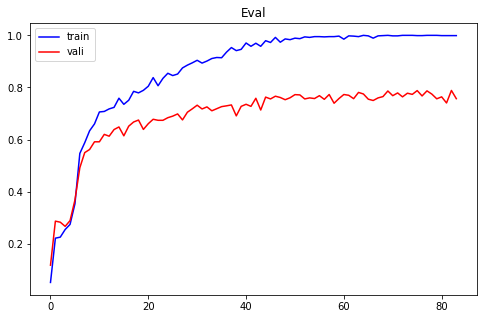

In [4]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

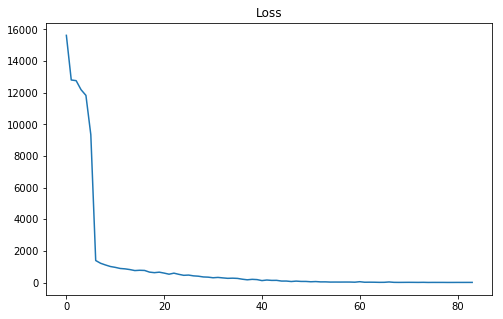

In [5]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

In [6]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.60      1.00      0.75        32
          1       0.73      0.75      0.74       131
          2       0.88      0.51      0.64       179
          3       0.69      0.87      0.77        53
          4       0.56      0.72      0.63        88
          5       0.74      0.74      0.74       205
          6       0.50      1.00      0.67         8
          7       0.88      0.50      0.64       230
          8       0.66      0.81      0.73        75
          9       0.33      0.81      0.47        58
         10       0.97      0.90      0.93       255
         11       0.49      0.91      0.64        47
         12       0.72      0.93      0.81        56
         13       0.94      0.68      0.79       226
         14       0.52      1.00      0.69        11
         15       0.60      1.00      0.75        40
         16       0.99      0.97      0.98       306

avg / total       0.82      0.77      0.77  

In [9]:
#二段训练
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.76      1.00      0.86        32
          1       0.80      0.76      0.78       131
          2       0.79      0.53      0.63       179
          3       0.79      0.85      0.82        53
          4       0.55      0.74      0.63        88
          5       0.75      0.68      0.71       205
          6       0.47      1.00      0.64         8
          7       0.86      0.61      0.72       230
          8       0.58      0.76      0.66        75
          9       0.34      0.69      0.46        58
         10       0.98      0.91      0.95       255
         11       0.52      0.91      0.67        47
         12       0.74      0.91      0.82        56
         13       0.91      0.75      0.82       226
         14       0.65      1.00      0.79        11
         15       0.61      1.00      0.75        40
         16       0.99      0.97      0.98       306

avg / total       0.82      0.78      0.79  

In [10]:
import h5py
filename = 'E:/Alibaba German AI Challenge/origin_DATA/round1_test_a_20181109.h5'
f = h5py.File(filename,'r')
test_s2 = f['sen2']

test = []
for i in range(0,test_s2.shape[0]):
    temp2 = test_s2[i].flatten()
    test.append(temp2)
test = np.array(test)

test_y = np.zeros((test.shape[0],17))

pred = tf.argmax(y_conv, 1)

test_x_0 = test[0:1500]
test_y_0 = test_y[0:1500]
P_0 = pred.eval(feed_dict={x:test_x_0, y_:test_y_0, keep_prob:1.0})

test_x_1 = test[1500:3000]
test_y_1 = test_y[1500:3000]
P_1 = pred.eval(feed_dict={x:test_x_1, y_:test_y_1, keep_prob:1.0})

test_x_2 = test[3000:4500]
test_y_2 = test_y[3000:4500]
P_2 = pred.eval(feed_dict={x:test_x_2, y_:test_y_2, keep_prob:1.0})

test_x_3 = test[4500:]
test_y_3 = test_y[4500:]
P_3 = pred.eval(feed_dict={x:test_x_3, y_:test_y_3, keep_prob:1.0})

P = np.hstack([P_0,P_1,P_2,P_3])

one_hot=tf.one_hot(P,17)
Pred_one_hot = sess.run(one_hot)
Pred_one_hot = Pred_one_hot.astype(np.int32)
out = pd.DataFrame(Pred_one_hot, columns = list(range(17)))
print(out.head())

outname = '5_conv_3_fc_10signal.csv'
out.to_csv(outname, index = False, header = False)

   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
1   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
3   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
4   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0


* 6层卷积+3层全连接
* 使用shuffle全部数据作为训练集，在train.h5中随机抽取5k样本做validation
* batch_size:1024
* learning_rate:1e-4
* 优化函数：Adam
* 激活函数：relu
* 只使用s2的10个信道
* 在损失函数中加入L2正则化项,正则化项系数设为1e-2

In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'
valiname = 'E:/Alibaba German AI Challenge/data_process/sample_of_training.npy'

data = np.load(filename)
vali = np.load(valiname)

train = data[:, 8192:]
vali = vali[:2000, 8192:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 10240])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 10])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 10, 64])
b_conv1_1 = bias_variable([64])

w_conv1_2 = weight_variable([3, 3, 64, 64])
b_conv1_2 = bias_variable([64])

h_conv1_1 = tf.nn.relu(conv2d(x_image, w_conv1_1) + b_conv1_1)
h_conv1_2 = tf.nn.relu(conv2d(h_conv1_1, w_conv1_2) + b_conv1_2)
h_pool1 = max_pool_2x2(h_conv1_2)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2)
h_pool2 = max_pool_2x2(h_conv2_2)

# fc_3
w_conv3_1 = weight_variable([3, 3, 128, 256])
b_conv3_1 = bias_variable([256])

w_conv3_2 = weight_variable([3, 3, 256, 256])
b_conv3_2 = bias_variable([256])

h_conv3_1 = tf.nn.relu(conv2d(h_pool2, w_conv3_1) + b_conv3_1)
h_conv3_2 = tf.nn.relu(conv2d(h_conv3_1, w_conv3_2) + b_conv3_2)
h_pool3 = max_pool_2x2(h_conv3_2)


# flatten
h_pool2_flat = tf.reshape(h_pool3, [-1, 4*4*256])

# densely connected layer
w_fc1 = weight_variable([4*4*256, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([1024, 1024])
b_fc2 = bias_variable([1024])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([1024, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
gamma = 1e-2
delta = 1e-7
learning_rate = 1e-4
L2_norm = gamma*(tf.norm(w_fc3)+tf.norm(w_fc2)+tf.norm(w_fc1)+
                 tf.norm(w_conv1_1)+tf.norm(w_conv1_2)+tf.norm(w_conv2_1)+tf.norm(w_conv2_2)+tf.norm(w_conv3_1)+tf.norm(w_conv3_2))
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+ L2_norm
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 1024
step_num = 18000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))



The shape of train is  (50989, 10257)
The shape of vali is  (2000, 10257)
step 0, train accuracy 0.0683594, vali accuracy 0.103, train loss 15380.7
step 200, train accuracy 0.110352, vali accuracy 0.177, train loss 14687
step 400, train accuracy 0.163086, vali accuracy 0.2495, train loss 13817.7
step 600, train accuracy 0.203125, vali accuracy 0.2945, train loss 13150.4
step 800, train accuracy 0.231445, vali accuracy 0.317, train loss 12681.3
step 1000, train accuracy 0.224609, vali accuracy 0.3095, train loss 12801.2
step 1200, train accuracy 0.246094, vali accuracy 0.2985, train loss 12415.7
step 1400, train accuracy 0.272461, vali accuracy 0.298, train loss 11994
step 1600, train accuracy 0.256836, vali accuracy 0.3385, train loss 12256.6
step 1800, train accuracy 0.276367, vali accuracy 0.316, train loss 11926.6
step 2000, train accuracy 0.255859, vali accuracy 0.3245, train loss 12286.3
step 2200, train accuracy 0.25293, vali accuracy 0.352, train loss 12309.5
step 2400, train ac

In [5]:
import h5py
filename = 'E:/Alibaba German AI Challenge/origin_DATA/round1_test_a_20181109.h5'
f = h5py.File(filename,'r')
test_s2 = f['sen2']

test = []
for i in range(0,test_s2.shape[0]):
    temp2 = test_s2[i].flatten()
    test.append(temp2)
test = np.array(test)

test_y = np.zeros((test.shape[0],17))

pred = tf.argmax(y_conv, 1)

test_x_0 = test[0:1500]
test_y_0 = test_y[0:1500]
P_0 = pred.eval(feed_dict={x:test_x_0, y_:test_y_0, keep_prob:1.0})

test_x_1 = test[1500:3000]
test_y_1 = test_y[1500:3000]
P_1 = pred.eval(feed_dict={x:test_x_1, y_:test_y_1, keep_prob:1.0})

test_x_2 = test[3000:4500]
test_y_2 = test_y[3000:4500]
P_2 = pred.eval(feed_dict={x:test_x_2, y_:test_y_2, keep_prob:1.0})

test_x_3 = test[4500:]
test_y_3 = test_y[4500:]
P_3 = pred.eval(feed_dict={x:test_x_3, y_:test_y_3, keep_prob:1.0})

P = np.hstack([P_0,P_1,P_2,P_3])

one_hot=tf.one_hot(P,17)
Pred_one_hot = sess.run(one_hot)
Pred_one_hot = Pred_one_hot.astype(np.int32)
out = pd.DataFrame(Pred_one_hot, columns = list(range(17)))
print(out.head())

outname = '6_conv_3_fc_one_step.csv'
out.to_csv(outname, index = False, header = False)

   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
1   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
3   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
4   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0


In [6]:
#二段训练
addname = 'E:/Alibaba German AI Challenge/data_process/sample_of_training_10k.npy'
add = np.load(addname)

train = add[:, 8192:]

step_num = 3000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))

step 0, train accuracy 0.716797, vali accuracy 0.747, train loss 1916.55
step 200, train accuracy 0.958984, vali accuracy 0.8365, train loss 148.608
step 400, train accuracy 0.993164, vali accuracy 0.848, train loss 39.0702
step 600, train accuracy 1, vali accuracy 0.853, train loss 13.4419
step 800, train accuracy 1, vali accuracy 0.8535, train loss 7.75824


KeyboardInterrupt: 

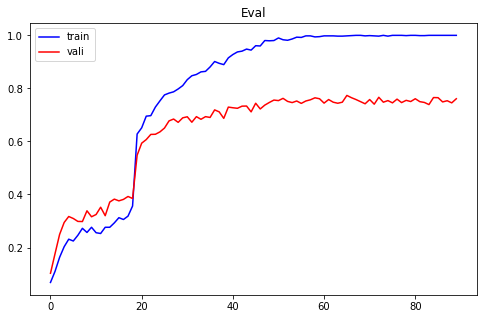

In [2]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

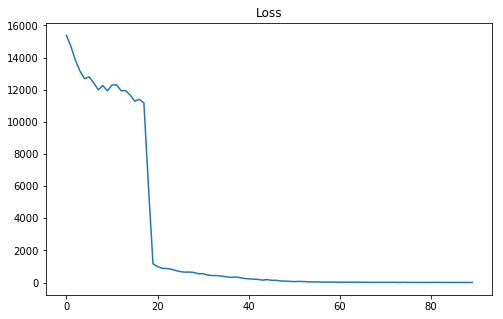

In [3]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()

In [4]:
#一段训练
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.53      1.00      0.70        32
          1       0.71      0.74      0.73       131
          2       0.91      0.48      0.63       179
          3       0.68      0.89      0.77        53
          4       0.57      0.74      0.64        88
          5       0.72      0.71      0.72       205
          6       0.36      1.00      0.53         8
          7       0.89      0.44      0.59       230
          8       0.63      0.76      0.69        75
          9       0.30      0.79      0.43        58
         10       0.97      0.89      0.93       255
         11       0.46      0.96      0.62        47
         12       0.68      0.93      0.79        56
         13       0.92      0.66      0.77       226
         14       0.55      1.00      0.71        11
         15       0.66      0.97      0.79        40
         16       0.99      0.96      0.98       306

avg / total       0.82      0.75      0.76  

In [7]:
#二段训练
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.88      0.88      0.88        32
          1       0.86      0.76      0.81       131
          2       0.81      0.78      0.79       179
          3       0.82      0.79      0.81        53
          4       0.70      0.62      0.66        88
          5       0.77      0.80      0.79       205
          6       0.88      0.88      0.88         8
          7       0.83      0.89      0.86       230
          8       0.78      0.71      0.74        75
          9       0.68      0.66      0.67        58
         10       0.95      0.96      0.96       255
         11       0.66      0.66      0.66        47
         12       0.88      0.80      0.84        56
         13       0.87      0.92      0.89       226
         14       1.00      0.82      0.90        11
         15       0.86      0.90      0.88        40
         16       0.98      0.99      0.99       306

avg / total       0.85      0.85      0.85  

In [8]:
import h5py
filename = 'E:/Alibaba German AI Challenge/origin_DATA/round1_test_a_20181109.h5'
f = h5py.File(filename,'r')
test_s2 = f['sen2']

test = []
for i in range(0,test_s2.shape[0]):
    temp2 = test_s2[i].flatten()
    test.append(temp2)
test = np.array(test)

test_y = np.zeros((test.shape[0],17))

pred = tf.argmax(y_conv, 1)

test_x_0 = test[0:1500]
test_y_0 = test_y[0:1500]
P_0 = pred.eval(feed_dict={x:test_x_0, y_:test_y_0, keep_prob:1.0})

test_x_1 = test[1500:3000]
test_y_1 = test_y[1500:3000]
P_1 = pred.eval(feed_dict={x:test_x_1, y_:test_y_1, keep_prob:1.0})

test_x_2 = test[3000:4500]
test_y_2 = test_y[3000:4500]
P_2 = pred.eval(feed_dict={x:test_x_2, y_:test_y_2, keep_prob:1.0})

test_x_3 = test[4500:]
test_y_3 = test_y[4500:]
P_3 = pred.eval(feed_dict={x:test_x_3, y_:test_y_3, keep_prob:1.0})

P = np.hstack([P_0,P_1,P_2,P_3])

one_hot=tf.one_hot(P,17)
Pred_one_hot = sess.run(one_hot)
Pred_one_hot = Pred_one_hot.astype(np.int32)
out = pd.DataFrame(Pred_one_hot, columns = list(range(17)))
print(out.head())

outname = '6_conv_3_fc_second_step.csv'
out.to_csv(outname, index = False, header = False)

   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
1   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
3   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
4   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0


##### 5conv+3fc， 使用从train中随即取得的10k样本做二段训练数据

In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/data_shuffle.npy'
valiname = 'E:/Alibaba German AI Challenge/data_process/sample_of_training.npy'

data = np.load(filename)
vali = np.load(valiname)

train = data[:, 8192:]
vali = vali[:2000, 8192:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 10240])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 10])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 10, 64])
b_conv1_1 = bias_variable([64])

h_conv1_1 = tf.nn.relu(conv2d(x_image, w_conv1_1) + b_conv1_1)
h_pool1 = max_pool_2x2(h_conv1_1)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2)
h_pool2 = max_pool_2x2(h_conv2_2)

# fc_3
w_conv3_1 = weight_variable([3, 3, 128, 256])
b_conv3_1 = bias_variable([256])

w_conv3_2 = weight_variable([3, 3, 256, 256])
b_conv3_2 = bias_variable([256])

h_conv3_1 = tf.nn.relu(conv2d(h_pool2, w_conv3_1) + b_conv3_1)
h_conv3_2 = tf.nn.relu(conv2d(h_conv3_1, w_conv3_2) + b_conv3_2)
h_pool3 = max_pool_2x2(h_conv3_2)


# flatten
h_pool2_flat = tf.reshape(h_pool3, [-1, 4*4*256])

# densely connected layer
w_fc1 = weight_variable([4*4*256, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([1024, 1024])
b_fc2 = bias_variable([1024])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([1024, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
gamma = 1e-2
delta = 1e-7
learning_rate = 1e-4
L2_norm = gamma*(tf.norm(w_fc3)+tf.norm(w_fc2)+tf.norm(w_fc1)+
                 tf.norm(w_conv1_1)+tf.norm(w_conv2_1)+tf.norm(w_conv2_2)+tf.norm(w_conv3_1)+tf.norm(w_conv3_2))
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+ L2_norm
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 

################    step one    ###############

##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 1024
step_num = 18000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))

        
################    step two    ###############

addname = 'E:/Alibaba German AI Challenge/data_process/sample_of_training_10k.npy'
add = np.load(addname)

train = add[:, 8192:]

step_num = 1000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))

The shape of train is  (50989, 10257)
The shape of vali is  (2000, 10257)
step 0, train accuracy 0.0556641, vali accuracy 0.0245, train loss 15582.7
step 200, train accuracy 0.264648, vali accuracy 0.349, train loss 12098.2
step 400, train accuracy 0.249023, vali accuracy 0.352, train loss 12239.1
step 600, train accuracy 0.331055, vali accuracy 0.419, train loss 10710.7
step 800, train accuracy 0.506836, vali accuracy 0.461, train loss 1746.14
step 1000, train accuracy 0.585938, vali accuracy 0.522, train loss 1336.02
step 1200, train accuracy 0.606445, vali accuracy 0.5445, train loss 1245.99
step 1400, train accuracy 0.640625, vali accuracy 0.5735, train loss 1094.65
step 1600, train accuracy 0.700195, vali accuracy 0.6125, train loss 976.057
step 1800, train accuracy 0.703125, vali accuracy 0.627, train loss 919.429
step 2000, train accuracy 0.725586, vali accuracy 0.624, train loss 862.748
step 2200, train accuracy 0.741211, vali accuracy 0.64, train loss 788.206
step 2400, train 

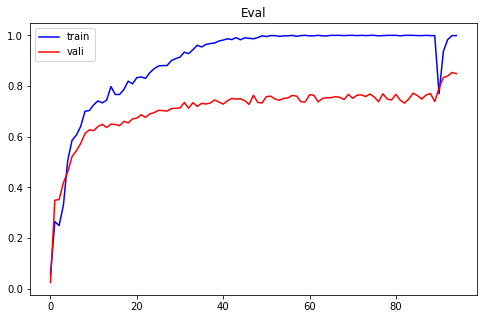

In [2]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

In [3]:
import h5py
filename = 'E:/Alibaba German AI Challenge/origin_DATA/round1_test_a_20181109.h5'
f = h5py.File(filename,'r')
test_s2 = f['sen2']

test = []
for i in range(0,test_s2.shape[0]):
    temp2 = test_s2[i].flatten()
    test.append(temp2)
test = np.array(test)

test_y = np.zeros((test.shape[0],17))

pred = tf.argmax(y_conv, 1)

test_x_0 = test[0:1500]
test_y_0 = test_y[0:1500]
P_0 = pred.eval(feed_dict={x:test_x_0, y_:test_y_0, keep_prob:1.0})

test_x_1 = test[1500:3000]
test_y_1 = test_y[1500:3000]
P_1 = pred.eval(feed_dict={x:test_x_1, y_:test_y_1, keep_prob:1.0})

test_x_2 = test[3000:4500]
test_y_2 = test_y[3000:4500]
P_2 = pred.eval(feed_dict={x:test_x_2, y_:test_y_2, keep_prob:1.0})

test_x_3 = test[4500:]
test_y_3 = test_y[4500:]
P_3 = pred.eval(feed_dict={x:test_x_3, y_:test_y_3, keep_prob:1.0})

P = np.hstack([P_0,P_1,P_2,P_3])

one_hot=tf.one_hot(P,17)
Pred_one_hot = sess.run(one_hot)
Pred_one_hot = Pred_one_hot.astype(np.int32)
out = pd.DataFrame(Pred_one_hot, columns = list(range(17)))
print(out.head())

outname = '5_conv_3_fc_two_step.csv'
out.to_csv(outname, index = False, header = False)

   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
1   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0
2   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
3   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
4   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0


In [4]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.74      0.88      0.80        32
          1       0.79      0.79      0.79       131
          2       0.78      0.78      0.78       179
          3       0.75      0.81      0.78        53
          4       0.67      0.69      0.68        88
          5       0.80      0.78      0.79       205
          6       0.78      0.88      0.82         8
          7       0.88      0.83      0.85       230
          8       0.79      0.65      0.72        75
          9       0.60      0.60      0.60        58
         10       0.95      0.96      0.95       255
         11       0.62      0.77      0.69        47
         12       0.90      0.82      0.86        56
         13       0.85      0.89      0.87       226
         14       1.00      1.00      1.00        11
         15       0.92      0.88      0.90        40
         16       0.98      0.99      0.99       306

avg / total       0.85      0.85      0.85  

In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/s2/s2_data_shuffle.npy'
valiname = 'E:/Alibaba German AI Challenge/data_process/sample_of_training.npy'

data = np.load(filename)
vali = np.load(valiname)

train = data
vali = vali[:2000, 8192:]

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 10240])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 10])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 10, 64])
b_conv1_1 = bias_variable([64])

h_conv1_1 = tf.nn.relu(conv2d(x_image, w_conv1_1) + b_conv1_1)
h_pool1 = max_pool_2x2(h_conv1_1)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2)
h_pool2 = max_pool_2x2(h_conv2_2)

# fc_3
w_conv3_1 = weight_variable([3, 3, 128, 256])
b_conv3_1 = bias_variable([256])

w_conv3_2 = weight_variable([3, 3, 256, 256])
b_conv3_2 = bias_variable([256])

h_conv3_1 = tf.nn.relu(conv2d(h_pool2, w_conv3_1) + b_conv3_1)
h_conv3_2 = tf.nn.relu(conv2d(h_conv3_1, w_conv3_2) + b_conv3_2)
h_pool3 = max_pool_2x2(h_conv3_2)


# flatten
h_pool2_flat = tf.reshape(h_pool3, [-1, 4*4*256])

# densely connected layer
w_fc1 = weight_variable([4*4*256, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([1024, 1024])
b_fc2 = bias_variable([1024])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([1024, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
gamma = 1e-2
delta = 1e-7
learning_rate = 1e-4
L2_norm = gamma*(tf.norm(w_fc3)+tf.norm(w_fc2)+tf.norm(w_fc1)+
                 tf.norm(w_conv1_1)+tf.norm(w_conv2_1)+tf.norm(w_conv2_2)+tf.norm(w_conv3_1)+tf.norm(w_conv3_2))
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+ L2_norm
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 1024
step_num = 10000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))



The shape of train is  (50989, 10257)
The shape of vali is  (2000, 10257)
step 0, train accuracy 0.0742188, vali accuracy 0.016, train loss 15284.6
step 200, train accuracy 0.167969, vali accuracy 0.379, train loss 13728.1
step 400, train accuracy 0.260742, vali accuracy 0.301, train loss 12089.7
step 600, train accuracy 0.307617, vali accuracy 0.3305, train loss 11328.5
step 800, train accuracy 0.344727, vali accuracy 0.38, train loss 10605.5
step 1000, train accuracy 0.417969, vali accuracy 0.421, train loss 8879.96
step 1200, train accuracy 0.542969, vali accuracy 0.508, train loss 1526.55
step 1400, train accuracy 0.567383, vali accuracy 0.552, train loss 1297.96
step 1600, train accuracy 0.608398, vali accuracy 0.581, train loss 1173.99
step 1800, train accuracy 0.641602, vali accuracy 0.597, train loss 1048.36
step 2000, train accuracy 0.669922, vali accuracy 0.6275, train loss 992.747
step 2200, train accuracy 0.679688, vali accuracy 0.607, train loss 944.453
step 2400, train ac

In [2]:
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))


step 0, train accuracy 0.980469, vali accuracy 0.7325, train loss 75.3242
step 200, train accuracy 0.992188, vali accuracy 0.7555, train loss 54.0905
step 400, train accuracy 0.987305, vali accuracy 0.7475, train loss 56.2776
step 600, train accuracy 0.983398, vali accuracy 0.7335, train loss 78.6474
step 800, train accuracy 0.992188, vali accuracy 0.7555, train loss 46.111
step 1000, train accuracy 0.995117, vali accuracy 0.744, train loss 41.122
step 1200, train accuracy 0.996094, vali accuracy 0.7525, train loss 33.7258
step 1400, train accuracy 0.992188, vali accuracy 0.754, train loss 39.7605
step 1600, train accuracy 0.994141, vali accuracy 0.761, train loss 39.3283
step 1800, train accuracy 0.995117, vali accuracy 0.748, train loss 37.6062
step 2000, train accuracy 0.992188, vali accuracy 0.751, train loss 38.5665
step 2200, train accuracy 0.994141, vali accuracy 0.779, train loss 34.4143
step 2400, train accuracy 0.99707, vali accuracy 0.7605, train loss 26.7511
step 2600, trai

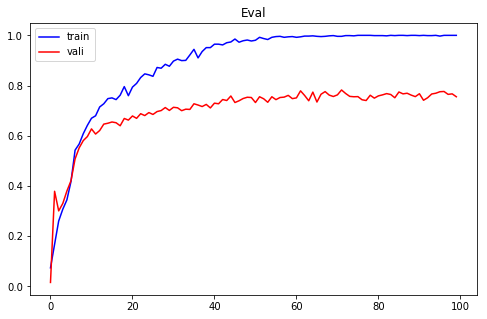

In [3]:
import matplotlib.pyplot as plt

xx = list(range(len(train_Eval)))

plt.figure(figsize = (8,5))
plt.plot(xx,train_Eval, color = 'blue', label = 'train')
plt.plot(xx,vali_Eval, color = 'red', label = 'vali')
plt.title('Eval')
plt.legend()
plt.show()

In [4]:
from sklearn.metrics import classification_report
pred = y_conv.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
train_val_y = np.argmax(vali[:,-17:],axis = 1)
pred_y = np.argmax(pred, axis = 1)
print (classification_report(train_val_y, pred_y))

             precision    recall  f1-score   support

          0       0.60      1.00      0.75        32
          1       0.80      0.69      0.74       131
          2       0.88      0.45      0.60       179
          3       0.75      0.89      0.81        53
          4       0.53      0.74      0.62        88
          5       0.70      0.75      0.72       205
          6       0.33      1.00      0.50         8
          7       0.90      0.58      0.70       230
          8       0.63      0.80      0.71        75
          9       0.38      0.76      0.51        58
         10       0.97      0.91      0.94       255
         11       0.46      0.96      0.62        47
         12       0.66      0.93      0.77        56
         13       0.94      0.64      0.76       226
         14       0.65      1.00      0.79        11
         15       0.62      1.00      0.76        40
         16       1.00      0.98      0.99       306

avg / total       0.82      0.77      0.77  

In [5]:
import h5py
filename = 'E:/Alibaba German AI Challenge/origin_DATA/round1_test_a_20181109.h5'
f = h5py.File(filename,'r')
test_s2 = f['sen2']

test = []
for i in range(0,test_s2.shape[0]):
    temp2 = test_s2[i].flatten()
    test.append(temp2)
test = np.array(test)

test_y = np.zeros((test.shape[0],17))

pred = tf.argmax(y_conv, 1)

test_x_0 = test[0:1500]
test_y_0 = test_y[0:1500]
P_0 = pred.eval(feed_dict={x:test_x_0, y_:test_y_0, keep_prob:1.0})

test_x_1 = test[1500:3000]
test_y_1 = test_y[1500:3000]
P_1 = pred.eval(feed_dict={x:test_x_1, y_:test_y_1, keep_prob:1.0})

test_x_2 = test[3000:4500]
test_y_2 = test_y[3000:4500]
P_2 = pred.eval(feed_dict={x:test_x_2, y_:test_y_2, keep_prob:1.0})

test_x_3 = test[4500:]
test_y_3 = test_y[4500:]
P_3 = pred.eval(feed_dict={x:test_x_3, y_:test_y_3, keep_prob:1.0})

P = np.hstack([P_0,P_1,P_2,P_3])

one_hot=tf.one_hot(P,17)
Pred_one_hot = sess.run(one_hot)
Pred_one_hot = Pred_one_hot.astype(np.int32)
out = pd.DataFrame(Pred_one_hot, columns = list(range(17)))
print(out.head())

outname = '5_conv_3_fc_new.csv'
out.to_csv(outname, index = False, header = False)

   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
1   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0
2   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0
3   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
4   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0


In [1]:
# start tensorflow interactiveSession                              
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import random
import h5py

filename = 'E:/Alibaba German AI Challenge/data_process/s2/s2_data_shuffle.npy'

data = np.load(filename)

train_x = data[:50000,:3072]
vali_x = data[50000:,:3072]
train_y = data[:50000,-17:]
vali_y = data[50000:,-17:]
train = np.hstack((train_x,train_y))
vali = np.hstack((vali_x,vali_y))

print('The shape of train is ',train.shape)
print('The shape of vali is ',vali.shape)

sess = tf.InteractiveSession()

#####################################################     Net Define     ##################################################### 

# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Create the model
# placeholder
x = tf.placeholder("float", [None, 3072])
y_ = tf.placeholder("float", [None, 17])
keep_prob = tf.placeholder("float")
x_image = tf.reshape(x, [-1, 32, 32, 3])

# first convolutinal layer
w_conv1_1 = weight_variable([3, 3, 3, 64])
b_conv1_1 = bias_variable([64])

h_conv1_1 = tf.nn.relu(conv2d(x_image, w_conv1_1) + b_conv1_1)
h_pool1 = max_pool_2x2(h_conv1_1)

# second convolutional layer
w_conv2_1 = weight_variable([3, 3, 64, 128])
b_conv2_1 = bias_variable([128])

w_conv2_2 = weight_variable([3, 3, 128, 128])
b_conv2_2 = bias_variable([128])

h_conv2_1 = tf.nn.relu(conv2d(h_pool1, w_conv2_1) + b_conv2_1)
h_conv2_2 = tf.nn.relu(conv2d(h_conv2_1, w_conv2_2) + b_conv2_2)
h_pool2 = max_pool_2x2(h_conv2_2)

# fc_3
w_conv3_1 = weight_variable([3, 3, 128, 256])
b_conv3_1 = bias_variable([256])

w_conv3_2 = weight_variable([3, 3, 256, 256])
b_conv3_2 = bias_variable([256])

h_conv3_1 = tf.nn.relu(conv2d(h_pool2, w_conv3_1) + b_conv3_1)
h_conv3_2 = tf.nn.relu(conv2d(h_conv3_1, w_conv3_2) + b_conv3_2)
h_pool3 = max_pool_2x2(h_conv3_2)


# flatten
h_pool2_flat = tf.reshape(h_pool3, [-1, 4*4*256])

# densely connected layer
w_fc1 = weight_variable([4*4*256, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

# dropout
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# fc_2
w_fc2 = weight_variable([1024, 1024])
b_fc2 = bias_variable([1024])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, w_fc2) + b_fc2)

# dropout
h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

# readout layer
w_fc3 = weight_variable([1024, 17])
b_fc3 = bias_variable([17])

y_conv = tf.nn.softmax(tf.matmul(h_fc2_drop, w_fc3) + b_fc3)

# train and evaluate the model
#交叉熵作为损失函数
gamma = 1e-2
delta = 1e-7
learning_rate = 1e-5
L2_norm = gamma*(tf.norm(w_fc3)+tf.norm(w_fc2)+tf.norm(w_fc1)+
                 tf.norm(w_conv1_1)+tf.norm(w_conv2_1)+tf.norm(w_conv2_2)+tf.norm(w_conv3_1)+tf.norm(w_conv3_2))
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))+ L2_norm
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv+delta))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
sess.run(tf.global_variables_initializer())


#####################################################       Train     ##################################################### 


##随机抽取一部分作为一个mini-batch
def get_batch(data, batch_size):
    sample = random.sample(list(data),batch_size)
    sample = np.array(sample)
    train_x = sample[:,:-17]
    train_y = sample[:,-17:]
    
    return train_x, train_y

Loss = []
vali_Eval = []
train_Eval = []

batch_size = 256
step_num = 10000
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))



The shape of train is  (50000, 3089)
The shape of vali is  (989, 3089)
step 0, train accuracy 0.0664062, vali accuracy 0.0515672, train loss 3856.81
step 200, train accuracy 0.0703125, vali accuracy 0.10819, train loss 3806.85
step 400, train accuracy 0.0820312, vali accuracy 0.0869565, train loss 3784.23
step 600, train accuracy 0.132812, vali accuracy 0.109201, train loss 3582.71
step 800, train accuracy 0.109375, vali accuracy 0.137513, train loss 3667.35
step 1000, train accuracy 0.117188, vali accuracy 0.138524, train loss 3627.39
step 1200, train accuracy 0.148438, vali accuracy 0.159757, train loss 3503.39
step 1400, train accuracy 0.144531, vali accuracy 0.163802, train loss 3522.97
step 1600, train accuracy 0.144531, vali accuracy 0.164813, train loss 3534.25
step 1800, train accuracy 0.183594, vali accuracy 0.164813, train loss 3373.14
step 2000, train accuracy 0.171875, vali accuracy 0.167846, train loss 3399.95
step 2200, train accuracy 0.136719, vali accuracy 0.176946, tra

In [2]:
for i in range(step_num):
    batch_x,batch_y = get_batch(train,batch_size)
    train_step.run(feed_dict={x:batch_x, y_:batch_y, keep_prob:0.5})
    if i%200 == 0:
        temp_loss = cross_entropy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        vali_accuracy = accuracy.eval(feed_dict={x:vali[:,:-17], y_:vali[:,-17:], keep_prob:1.0})
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        Loss.append(temp_loss)
        vali_Eval.append(vali_accuracy)
        train_Eval.append(train_accuracy)
        train_accuracy = accuracy.eval(feed_dict={x:batch_x, y_:batch_y, keep_prob:1.0})
        print ("step %d, train accuracy %g, vali accuracy %g, train loss %g" %(i, train_accuracy, vali_accuracy, temp_loss))

step 0, train accuracy 0.382812, vali accuracy 0.422649, train loss 494.394
step 200, train accuracy 0.457031, vali accuracy 0.419616, train loss 421.305
step 400, train accuracy 0.40625, vali accuracy 0.433771, train loss 440.116
step 600, train accuracy 0.457031, vali accuracy 0.419616, train loss 434.673
step 800, train accuracy 0.453125, vali accuracy 0.421638, train loss 419.787
step 1000, train accuracy 0.4375, vali accuracy 0.433771, train loss 447.143
step 1200, train accuracy 0.429688, vali accuracy 0.430738, train loss 454.377
step 1400, train accuracy 0.488281, vali accuracy 0.426694, train loss 401.382
step 1600, train accuracy 0.4375, vali accuracy 0.434783, train loss 458.675
step 1800, train accuracy 0.476562, vali accuracy 0.450961, train loss 419.717
step 2000, train accuracy 0.441406, vali accuracy 0.438827, train loss 443.536
step 2200, train accuracy 0.523438, vali accuracy 0.435794, train loss 388.118
step 2400, train accuracy 0.476562, vali accuracy 0.448938, trai

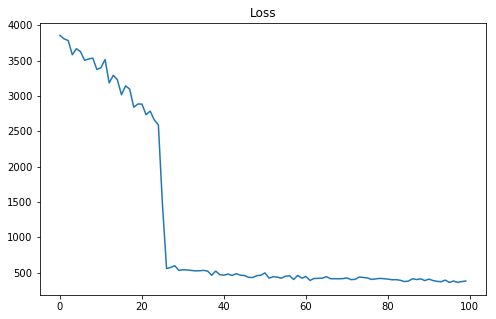

In [3]:
import matplotlib.pyplot as plt

xx = list(range(len(Loss)))

plt.figure(figsize = (8,5))
plt.plot(xx,Loss)
plt.title('Loss')
plt.show()